In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt


# Descarga de datos
tickers = ["AAPL","MSFT","GOOGL","AMZN"]
weights = np.array([0.25,0.25,0.25,0.25])

end = dt.datetime.today()
start = end - dt.timedelta(days=252*10)

data = yf.download(tickers,start=start,end=end)["Close"]
returns = data.pct_change().dropna()


C:\Users\pablo\AppData\Local\Temp\ipykernel_9564\1440839642.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers,start=start,end=end)["Close"]
[*********************100%***********************]  4 of 4 completed


In [2]:
lambda_ = 0.94

ewma_var = returns.var().copy()
ewma_vol_series = []

for t in range(len(returns)):
    r_t = returns.iloc[t]
    ewma_var = lambda_ * ewma_var + (1 - lambda_) * (r_t ** 2)
    ewma_vol_series.append(np.sqrt(ewma_var))

ewma_vol_df = pd.DataFrame(ewma_vol_series, 
                           index=returns.index, 
                           columns=returns.columns)

In [3]:
corr_matrix = returns.corr()
L_corr = np.linalg.cholesky(corr_matrix)

In [4]:
n_sim = 10000
n_days = 252
n_assets = len(tickers)

sigma_t = ewma_vol_df.iloc[-1].values
portfolio_paths = np.zeros((n_sim, n_days))

for s in range(n_sim):

    sigma = sigma_t.copy()
    prices_sim = np.ones(n_assets)

    for t in range(n_days):

        z = np.random.normal(size=n_assets)
        correlated = L_corr @ z

        r = sigma * correlated

        prices_sim = prices_sim * (1 + r)

        port_ret = np.dot(weights, r)

        if t == 0:
            portfolio_paths[s, t] = 1 + port_ret
        else:
            portfolio_paths[s, t] = portfolio_paths[s, t-1] * (1 + port_ret)

        sigma = np.sqrt(lambda_ * sigma**2 + (1 - lambda_) * (r**2))

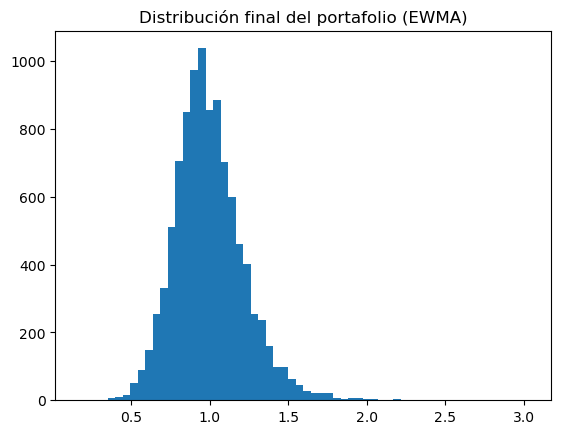

VaR 95%: 0.3258458845990332
Expected Shortfall 95%: 0.40519634731873566


In [5]:
final_values = portfolio_paths[:,-1]

plt.hist(final_values,bins=60)
plt.title("Distribución final del portafolio (EWMA)")
plt.show()

var_95 = np.percentile(final_values,5)
es_95 = final_values[final_values<=var_95].mean()

print("VaR 95%:",1-var_95)
print("Expected Shortfall 95%:",1-es_95)

VaR al 95% a 15 días

Calcular VaR (%) para tu portafolio a 15 días al 95% de confianza
- Con MGB con volatilidad constante
    - Usando 1 año de data histórica
    - Usando 3 años de data histórica
    - Usando 5 años de data histórica
    - Usando 10 años de data histórica
- Con EWMA
    - Usando 1 año de data histórica. Lambda =.94
    - Usando 3 años de data histórica. Lambda =.94
    - Usando 5 años de data histórica. Lambda =.94
    - Usando 10 años de data histórica. Lambda =.94
- Con EWMA
    - Usando 1 año de data histórica. Lambda =.8
    - Usando 3 años de data histórica. Lambda =.8
    - Usando 5 años de data histórica. Lambda =.8
    - Usando 10 años de data histórica. Lambda =.8

Construir una tabla comparativa en Python

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm

stocks = ["BAC","F","PFE","HPE"]
weights = np.array([0.1,0.3,0.4,0.2])

confidence = 0.95
z = norm.ppf(1 - confidence)   
horizon = 15                   


def get_portfolio_returns(years):

    end = dt.datetime.today()
    start = end - dt.timedelta(days=252*years)

    prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]

    returns = prices.pct_change().dropna()

    portfolio_returns = returns @ weights

    return portfolio_returns


# FUNCIÓN: VOLATILIDAD CONSTANTE (MGB)

def constant_volatility(portfolio_returns):

    return portfolio_returns.std()


# FUNCIÓN: VOLATILIDAD EWMA

def ewma_volatility(portfolio_returns, lambda_):

    var = portfolio_returns.var()

    for r in portfolio_returns:
        var = lambda_ * var + (1 - lambda_) * r**2

    return np.sqrt(var)


# FUNCIÓN: CALCULAR VaR %

def calculate_var_percent(volatility):

    var = - z * volatility * np.sqrt(horizon)

    return var * 100


# CÁLCULO PARA TODOS LOS CASOS

years_list = [1, 3, 5, 10]

results = []

for years in years_list:

    portfolio_returns = get_portfolio_returns(years)

    # ---- MGB ----
    vol_const = constant_volatility(portfolio_returns)
    var_const = calculate_var_percent(vol_const)

    results.append({
        "Metodo": "MGB Volatilidad Constante",
        "Lambda": "-",
        "Años": years,
        "VaR (%)": var_const
    })

    # EWMA lambda 0.94 
    vol_ewma_94 = ewma_volatility(portfolio_returns, 0.94)
    var_ewma_94 = calculate_var_percent(vol_ewma_94)

    results.append({
        "Metodo": "EWMA",
        "Lambda": 0.94,
        "Años": years,
        "VaR (%)": var_ewma_94
    })

    # EWMA lambda 0.8 
    vol_ewma_80 = ewma_volatility(portfolio_returns, 0.8)
    var_ewma_80 = calculate_var_percent(vol_ewma_80)

    results.append({
        "Metodo": "EWMA",
        "Lambda": 0.8,
        "Años": years,
        "VaR (%)": var_ewma_80
    })


# TABLA COMPARATIVA

var_table = pd.DataFrame(results)

var_table = var_table.pivot_table(
    index=["Metodo", "Lambda"],
    columns="Años",
    values="VaR (%)"
)

var_table = var_table.round(9)

print("\nVaR (%) a 15 días con 95% de confianza:\n")
print(var_table)

C:\Users\pablo\AppData\Local\Temp\ipykernel_9564\1342624674.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]
C:\Users\pablo\AppData\Local\Temp\ipykernel_9564\1342624674.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]
C:\Users\pablo\AppData\Local\Temp\ipykernel_9564\1342624674.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]
C:\Users\pablo\AppData\Local\Temp\ipykernel_9564\1342624674.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]



VaR (%) a 15 días con 95% de confianza:

Años                                    1          3          5          10
Metodo                    Lambda                                           
EWMA                      0.8     7.600700   7.600700   7.600700   7.600700
                          0.94    9.081726   9.081800   9.081800   9.081800
MGB Volatilidad Constante -       7.600711  10.278836  10.975578  12.078038
